# Introduction and Imports

This notebook provides a step-by-step tutorial for calibrating data. This tutorial simulates the data to be calibrated on-the-fly and requires a few extra packages for simulation and covariance model building. Visibility simulation is performed using the `matvis` wrapper provided in `hera_sim`. This requires `pyradiosky`, `pyuvdata`, and `pyuvsim`, as well as these packages' dependencies. Visibility and beam data is managed with tools provided by `pyuvdata`. For simplicity, this tutorial uses an analytic beam model. <b>If you find that there are any topics in this notebook that should be more clearly covered, please raise an issue with your concerns.</b>

In [1]:
# Packages required for calibration
import corrcal  # For performing the likelihood and gradient operations
import numpy as np
from scipy.optimize import minimize  # For running calibration

# Packages to help with covariance model building and simulation
import hera_sim
import vis_cpu  # For coordinate transformations
from astropy import constants, units
from astropy.coordinates import Latitude, Longitude, AltAz
from astropy.coordinates import EarthLocation, SkyCoord
from astropy_healpix import HEALPix  # For interpolating to the image plane
from astropy.time import Time
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from pyradiosky import SkyModel
from pyuvdata import UVBeam  # If using a realistic beam model
from pyuvsim import AnalyticBeam  # If using an analytic beam model

# Other packages
import healpy  # For various operations on the sphere
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d  # For visualization purposes
%matplotlib inline

## Setup 

The setup section of this tutorial contains two parts: preparing data products for simulation, and preparing data products for covariance model building. Some of the objects are reused between the two steps, and the example shown here may not be appropriate for every use case, as different experiments may use different data structures and simulation tools.

### Point Source Model

For this example, information about the point sources is stored in a `npz` archive. The sources are characterized by their right ascension and declination, as well as their flux density. The source catalog has source counts consistent with the low-frequency radio sky, but does not feature any sort of clustering. Since this is a single-channel example, there is no need for spectral evolution information. Rather than cover the full sky, the provided example source catalog only covers a $30^\circ \times 30^\circ$ patch of the sky, centered at zenith for the chosen observation time and observatory location.

In [2]:
source_catalog = corrcal.DATA_PATH / "example_source_catalog.npz"
catalog_info = dict(np.load(source_catalog))
fluxes = catalog_info["fluxes"] * getattr(units, str(catalog_info["flux_unit"]))
ra = catalog_info["ra"] * getattr(units, str(catalog_info["ra_unit"]))
dec = catalog_info["dec"] * getattr(units, str(catalog_info["dec_unit"]))

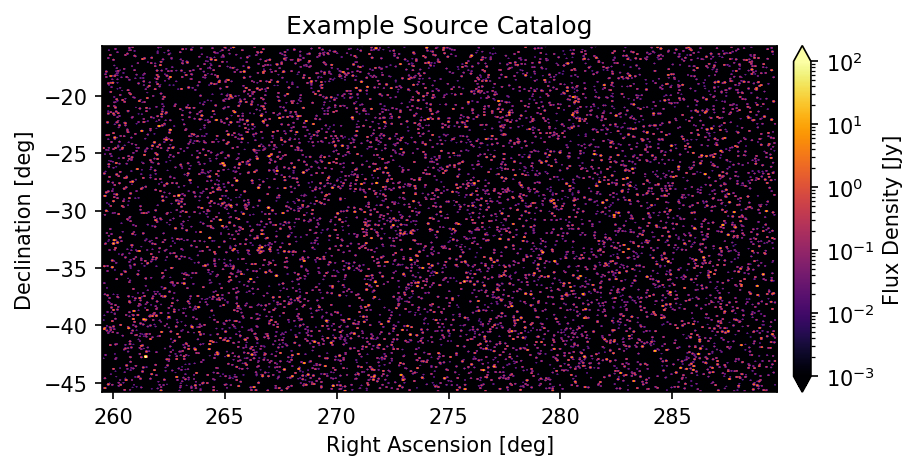

In [3]:
# Bin up the sources and plot the result to visualize the source catalog
buffer = 0.1 * units.deg
n_bins = 1025
ra_bounds = (
    (ra.min() - buffer).to(units.rad).value,
    (ra.max() + buffer).to(units.rad).value,
)
dec_bounds = (
    (dec.min() - buffer).to(units.rad).value,
    (dec.max() + buffer).to(units.rad).value,
)
ra_bins = np.linspace(*ra_bounds, n_bins+1)
dec_bins = np.linspace(*dec_bounds, n_bins+1)
binned_flux = binned_statistic_2d(
    ra.to(units.rad).value,
    dec.to(units.rad).value,
    fluxes.to(units.Jy).value,
    statistic="sum",
    bins=(ra_bins, dec_bins),
)[0]

# Smooth the binned flux to help with visualization.
kernel_width = 1 * units.arcmin.to(units.rad)
plot_ra = 0.5 * (ra_bins[1:]+ra_bins[:-1])
plot_ra -= plot_ra.mean()
plot_dec = 0.5 * (dec_bins[1:]+dec_bins[:-1])
plot_dec -= plot_dec.mean()
kernel = np.exp(
    -0.5 * plot_dec[:,None]**2 / kernel_width**2
) * np.exp(-0.5 * plot_ra[None,:]**2 / kernel_width**2)
smoothed_flux = np.abs(
    fftshift(ifft2(fft2(kernel) * fft2(binned_flux)))
)

# Now set up the plotting elements.
norm = plt.cm.colors.LogNorm(vmin=1e-3, vmax=1e2)
cmap = plt.cm.inferno.copy()
cmap.set_bad('k')
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
extent = np.array(ra_bounds + dec_bounds) * units.rad.to(units.deg)

# Finally, actually make the plot.
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("Example Source Catalog")
ax.imshow(smoothed_flux, origin="lower", aspect="auto", norm=norm, cmap=cmap, extent=extent)
fig.colorbar(smap, ax=ax, label="Flux Density [Jy]", extend="both", pad=0.02);

**Figure 1 |** Point source catalog used for this tutorial.

At this point, we have information about all of the point sources that will be used in simulation, and we will use a very small subset of these sources for calibration. For clarity, the relevant information is stored as follows:  
  
* Source fluxes are contained as `astropy` quantities in a `numpy` array in the object `fluxes`.
* Source positions are tracked through their right ascension and declination; both are contained as `astropy` quantities in `numpy` arrays.
    * The right ascensions are stored in the `ra` object.
    * The declinations are stored in the `dec` object.

### Diffuse Sky Setup

For this example, we will use a realization of a Gaussian random field with a $(1+\ell)^{-2}$ angular power spectrum (plus a monopole) as the diffuse sky component. The sky intensity will be scaled so that the power in the diffuse emission is somewhat comparable to the power in the point source emission.

In [4]:
max_Tsky = 500 * units.K
nside = 64
ell_max = 3*nside - 1
ells = np.arange(ell_max+1, dtype=float)
sky_pspec = 1 / (1+ells)**2
Tsky = healpy.synfast(sky_pspec, nside) * units.K
Tsky += np.abs(Tsky.min())  # Considering only emission and not absorption
Tsky *= max_Tsky / Tsky.max()

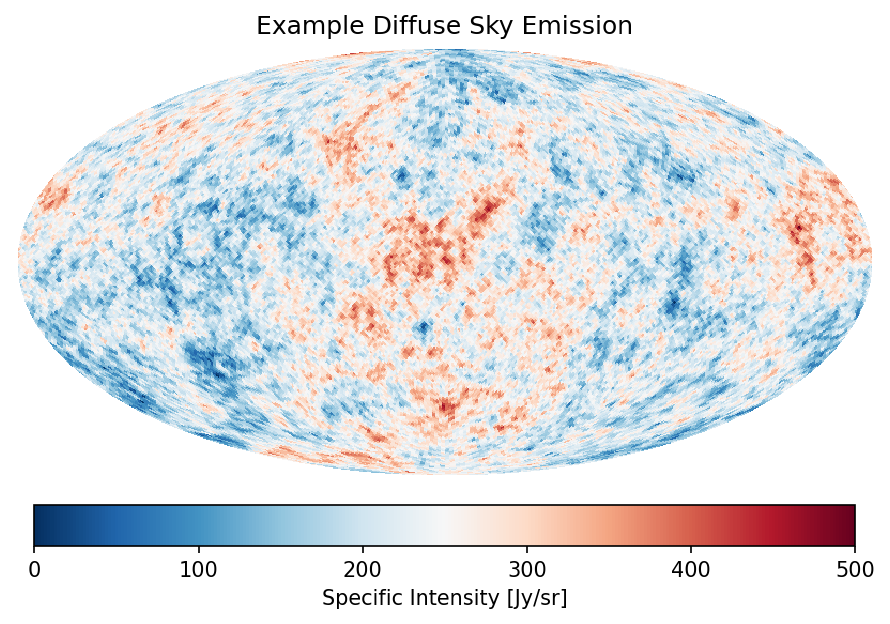

In [5]:
# Quickly visualize the diffuse component
plt.figure(figsize=(6,4), dpi=150)
healpy.mollview(
    Tsky.value,
    fig=1,
    title="",
    cmap="RdBu_r",
    cbar=False,
    norm=None,
    min=Tsky[Tsky>0].min().value,
    max=Tsky.max().value,
)

# Manually make the colorbar and title
norm = plt.cm.colors.Normalize(vmin=0, vmax=Tsky.max().value)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(
    smap,
    ax=plt.gca(),
    orientation="horizontal",
    label="Specific Intensity [Jy/sr]",
    shrink=0.95,
    pad=0.05,
)
plt.title("Example Diffuse Sky Emission");

**Figure 2 |** Diffuse component of the sky intensity used for this example. A monopole term has been added to ensure that the intensity is non-negative. Red regions are brighter than the average; blue regions are dimmer than the average.

### Simulation Setup

Now we'll finish setting things up for running visibility simulation. This requires setting up `SkyModel` and `UVData` objects, as well as defining the per-antenna beams. **Note that the observation time chosen here is chosen so that the point sources are uniformly distributed about zenith.**

In [6]:
# Required parameters for making a UVData object
obstime = 2459917.00243  # Julian date
integration_time = 10  # seconds
Ntimes = 1
freq = 150e6  # Hz
channel_width = 100e3  # Hz
Nfreqs = 1
polarizations = ["xx",]
array_layout = hera_sim.antpos.hex_array(3, outriggers=0, split_core=False)
latitude = -30.721527099609585  # Degrees
longitude = 21.42830467224121  # Degrees
altitude = 1073.0000000121072  # Meters

# Additional information.
diameter = 14

In [7]:
# Create the UVData object.
src_uvdata = hera_sim.io.empty_uvdata(
    Ntimes=Ntimes,
    start_time=obstime,
    integration_time=integration_time,
    Nfreqs=Nfreqs,
    start_freq=freq,
    channel_width=channel_width,
    array_layout=array_layout,
    polarizations=polarizations,
    telescope_location=[latitude, longitude, altitude],
)
# For sanity checks later.
diff_uvdata = src_uvdata.copy()

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [8]:
# Create the beam model.
beam = AnalyticBeam("airy", diameter=diameter)
beam_ids = [0,] * src_uvdata.Nants_data

In [9]:
# Generate the SkyModel for the source catalog.
source_stokes = np.zeros((4, 1, fluxes.size), dtype=float) * units.Jy
source_stokes[0,0] = fluxes
source_model = SkyModel(
    name=np.arange(fluxes.size).astype(str),
    ra=Longitude(ra),
    dec=Latitude(dec),
    stokes=source_stokes,
    spectral_type="flat",  # No spectral evolution
    component_type="point",
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [10]:
# Generate the SkyModel for the diffuse emission.
diffuse_stokes = np.zeros((4, 1, Tsky.size), dtype=float) * units.K
diffuse_stokes[0,0] = Tsky
diffuse_model = SkyModel(
    stokes=diffuse_stokes,
    hpx_inds=np.arange(Tsky.size),
    spectral_type="flat",
    component_type="healpix",
    nside=nside,
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

## Run Simulation

In [11]:
# Simulate the diffuse visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=diff_uvdata,
    sky_model=diffuse_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)
simulation.simulate();

In [12]:
# Simulate the point source visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=src_uvdata,
    sky_model=source_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)
simulation.simulate();

In [13]:
uvdata = src_uvdata.copy()
uvdata.data_array += diff_uvdata.data_array

## Prepare Model Covariance

The model covariance is decomposed in terms of smaller matrices via  
  
$$
    C = N + G \Delta \Delta^\dagger G^\dagger + G \Sigma \Sigma^\dagger G^\dagger,
$$
  
where $N$ is a diagonal matrix tracking the noise variance, $\Delta$ is the "diffuse" matrix describing covariances due to diffuse emission, $\Sigma$ is the "source" matrix tracking covariances due to the presence of point sources, and $G$ is the gain matrix. Preparing the model covariance consists of four major steps: sorting the data into redundant groups and selecting which baselines to use for calibration; estimating the variance from thermal noise; computing the diffuse matrix; and computing the source matrix. The per-antenna gains are the only free parameters and so are applied only during the calculation of the likelihood and its gradient.

### Diffuse Matrix

The vanilla version of `CorrCal` only considers correlations within a (quasi-)redundant group when treating the diffuse matrix. The dense form of the matrix is block-diagonal, and so the sparse form only keeps track of the block-diagonal elements. The following section shows how to compute the diffuse matrix elements, but there is a utility function `corrcal.models.compute_diffuse_matrix` that can compute this for you.

In [14]:
# Choosing this as the minimum baseline length more strongly enforces the
# approximation that there is no shared information between different redundant
# groups sourced from diffuse emission.
min_bl_length = np.sqrt(2) * diameter
min_group_size = 5  # This is somewhat arbitrary, but helps with computational cost
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_length=min_bl_length, min_group_size=min_group_size
)

The `ant_1_array` and `ant_2_array` objects track the first and second antennas in each baseline used for calibration. The `corrcal.gridding.make_groups_from_uvdata` function sorts these into redundant groups, and the bounds of these redundant groups are tracked in the `edges` array.

In [15]:
enu_antpos = uvdata.get_ENU_antpos()[0]
baselines = enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
np.allclose(baselines[edges[0]], baselines[edges[0]:edges[1]])

True

A given redundant block $R_{kk'}$ in the diffuse covariance $\Delta \Delta^\dagger$ can be computed in one of two ways. One way is in the $uv$-plane, via  
  
$$
    R_{kk'} = \int \tilde{A}(\vec{u}-\vec{u}_k)^* \tilde{A}(\vec{u} - \vec{u}_{k'}) P(\vec{u}) dudv,
$$
  
where $P(\vec{u})$ is the power spectrum of the diffuse emission in the $uv$-plane and $\tilde{A}$ is the Fourier transform of the beam. Alternatively, the diffuse covariance matrix elements can be computed in harmonic space, via  
  
$$
    R_{kk'} = \sum_\ell C_\ell \sum_m b_{\ell m}^k (b_{\ell m}^{k'})^*,
$$
  
where $C_\ell$ is the angular power spectrum of the diffuse emission, and $b_{\ell m}^k$ are the conjugate spherical harmonics of the beam transfer function for baseline $\vec{b}_k$ in the sense that  
  
$$
    A(\hat{n}) e^{-i2\pi\nu\vec{b}_k \cdot \hat{n}/c} = \sum_{\ell,m} b_{\ell m}^k Y_\ell^m(\hat{n})^*.
$$
  
The diffuse matrix is calculated by first computing each blocks in the diffuse covariance $R_{kk'}^r$ for each redundant group $r$, then computing the eigendecomposition  
  
$$
    R_{kk'}^r = Q_{ki} \Lambda_{ii} Q_{ik'}^\dagger,
$$
  
and keeping only the first $N_{\rm eig}$ eigenmodes so that  
  
$$
    \Sigma_{ki}^r = \lambda_i^{1/2} Q_{ki}.
$$
  
This example shows how to compute the diffuse matrix from the $uv$-plane.

In [16]:
# We need the beam power rather than the far-field response
beam.efield_to_power()

# The diffuse emission needs to be converted from K to Jy
diffuse_model.kelvin_to_jansky()
Tsky = diffuse_model.stokes[0,0].value

# Since the simulation is perfectly redundant, we'll just use one eigenmode
n_eig = 1

In [17]:
# Prepare the direction cosine grid.
uvws = freq * baselines / constants.c.si.value
u_max = np.linalg.norm(uvws, axis=1).max()
n_l = int(8 * u_max)
if n_l % 2 == 0:
    n_l += 1  # Ensure (l,m) = (0,0) is included.
lm_grid = np.linspace(-1, 1, n_l)  # Horizon-to-horizon
measure = (lm_grid[1]-lm_grid[0]) ** 2

In [18]:
# Prepare a local frame for coordinate transformations
observatory = EarthLocation(*uvdata.telescope_location*units.m)
local_frame = AltAz(
    location=observatory, obstime=Time(obstime, format="jd")
)

In [19]:
# Now interpolate the beam and sky to the (l,m) grid.
gridded_beam = np.zeros((n_l, n_l), dtype=float)
flat_Tsky = np.zeros_like(gridded_beam)
hpx_grid = HEALPix(nside=nside, order="ring", frame="icrs")

# This might not be the most efficient way, but it works.
for row, m in enumerate(lm_grid):
    # First, figure out what's above the horizon.
    l_mag = np.sqrt(m**2 + lm_grid**2)
    select = l_mag < 1
    if select.sum() == 0:
        continue  # There's nothing to do.
        
    # Compute the azimuth and zenith angle for each of these points.
    indices = np.argwhere(select).flatten()
    za = np.arcsin(l_mag[select])
    az = np.arctan2(m, lm_grid[select])
    
    # Interpolate the beam.
    beam_vals = beam.interp(
        az_array=az, za_array=za, freq_array=np.array([freq])
    )[0][0,0]
    if beam_vals.ndim == 3:
        # It seems like this differs between versions of pyuvsim.
        beam_vals = beam_vals[0,0]
    gridded_beam[row,select] = beam_vals
    
    # Interpolate the sky intensity.
    coords = SkyCoord(
        Longitude(np.pi/2 - az, unit="rad"),  # astropy uses E of N
        Latitude(np.pi/2 - za, unit="rad"),
        frame=local_frame,
    ).transform_to("icrs")
    flat_Tsky[row,select] = hpx_grid.interpolate_bilinear_skycoord(
        coords, Tsky
    ) / np.sqrt(1 - l_mag[select]**2)  # Apply sky projection effects.
    
# Wrap up preparations by computing the sky power spectrum.
sky_pspec = np.abs(
    np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(flat_Tsky * measure)))
) ** 2

In [20]:
# Now compute the diffuse matrix.
LM = np.array(np.meshgrid(lm_grid, lm_grid))
diff_mat = np.zeros((edges[-1], n_eig), dtype=complex)
for grp, (start, stop) in enumerate(zip(edges, edges[1:])):
    # Compute the beam transfer function for this block.
    fringe = np.exp(
        -2j * np.pi * np.einsum("bi,ilm->blm", uvws[start:stop,:2], LM)
    )
    kernel = np.fft.fftshift(
        np.fft.fft2(
            np.fft.ifftshift(
                gridded_beam[None,...] * fringe, axes=(1,2)
            ), axes=(1,2)
        ), axes=(1,2)
    )
    
    # Compute this block of the diffuse covariance.
    block = measure * np.einsum(
        "puv,quv,uv->pq", kernel, kernel.conj(), sky_pspec
    )
    
    # Take the eigendecomposition.
    eigvals, eigvecs = np.linalg.eigh(block)
    if eigvals[0] < eigvals[-1]:
        eigvals = eigvals[::-1]
        eigvecs = eigvecs[:,::-1]
    diff_mat[start:stop] = np.sqrt(eigvals[None,:n_eig]) * eigvecs[:,:n_eig]

In [21]:
# There is a convenient function that will do the calculation.
_diff_mat = corrcal.models.compute_diffuse_matrix(
    Tsky=Tsky,
    nside=nside,
    beam=beam,
    telescope_location=uvdata.telescope_location*units.m,
    obstime=obstime,
    freq=freq,
    enu_antpos=enu_antpos,
    ant_1_array=ant_1_array,
    ant_2_array=ant_2_array,
    edges=edges,
    n_eig=n_eig
)

In [22]:
np.allclose(diff_mat, _diff_mat)

True

In [23]:
# Now do a quick check that the amplitude of the diffuse matrix makes sense
diff_data = np.array(
    [
        diff_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

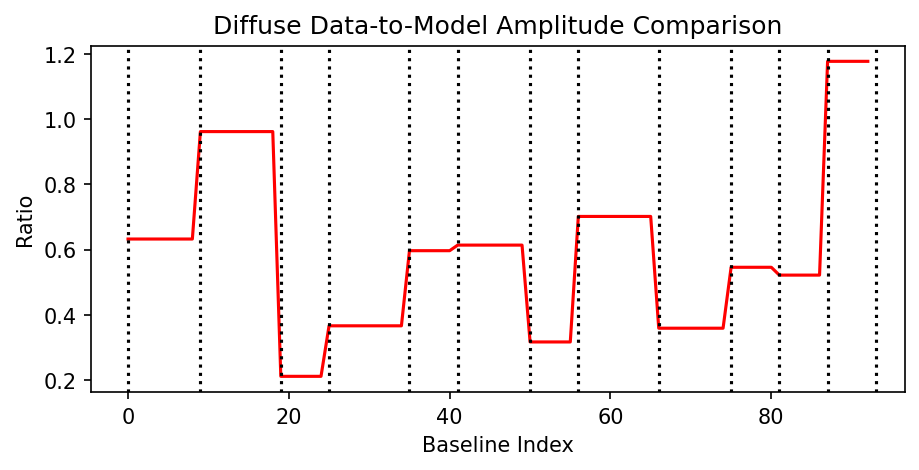

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Ratio")
ax.set_title("Diffuse Data-to-Model Amplitude Comparison")
ax.plot(np.abs(diff_data) / np.abs(diff_mat[:,0]), color='r')
for idx in edges:
    ax.axvline(idx, color='k', ls=':')

### Source Matrix

The source matrix is a bit more straightforward to compute, but still requires a bit of work. The source matrix element is written down as  
  
$$
    \Sigma_{kj} = A(\hat{n}_j) s_j e^{-i2\pi\nu\vec{b}_k \cdot \hat{n}_j},
$$
  
where $\hat{n}_j$ is the direction to the $j$-th source with flux $s_j$. So the procedure is to choose which sources to use for calibration, interpolate the beam to the source positions, and evaluate the fringe at the source positions.

In [25]:
# Convert the source positions to the local frame.
source_positions = SkyCoord(
    Longitude(ra), Latitude(dec), frame="icrs"
).transform_to(local_frame)

# Perform some selections before picking which sources to use.
above_horizon = source_positions.alt > 0

# This is arbitrary, but within the main lobe is reasonable.
near_zenith = source_positions.alt.deg > 80

# Again, the brightness cutoff is arbitrary.
is_bright = fluxes.to(units.Jy).value > 100

select = near_zenith | (is_bright & above_horizon)

In [26]:
src_az = Longitude(np.pi/2*units.rad - source_positions.az)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select].to(units.Jy).value

In [27]:
# UVBeam has azimuth run from East to North
src_az = Longitude(np.pi/2*units.rad - source_positions.az)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select].to(units.Jy).value

beam_vals = beam.interp(
    az_array=src_az, za_array=src_za, freq_array=np.array([freq]),
)[0][0,0,0]
if beam_vals.ndim == 2:
    # Again, this is a pyuvsim version thing
    beam_vals = beam_vals[0]
weighted_fluxes = beam_vals * src_flux

# Now choose the sources to use for calibration
n_src = 1
sort = np.argsort(weighted_fluxes)[::-1]
src_az = src_az[sort][:n_src]
src_za = src_za[sort][:n_src]

# The factor of 0.5 to match the matvis Stokes convention
src_flux = 0.5 * weighted_fluxes[sort][:n_src]

In [28]:
# Compute the unit vectors pointing to the sources
src_nhat = np.array(
    [np.sin(src_za)*np.cos(src_az), np.sin(src_za)*np.sin(src_az), np.cos(src_za)]
)
src_fringe = np.exp(-2j * np.pi * uvws @ src_nhat)
src_mat = src_flux[None,:] * src_fringe

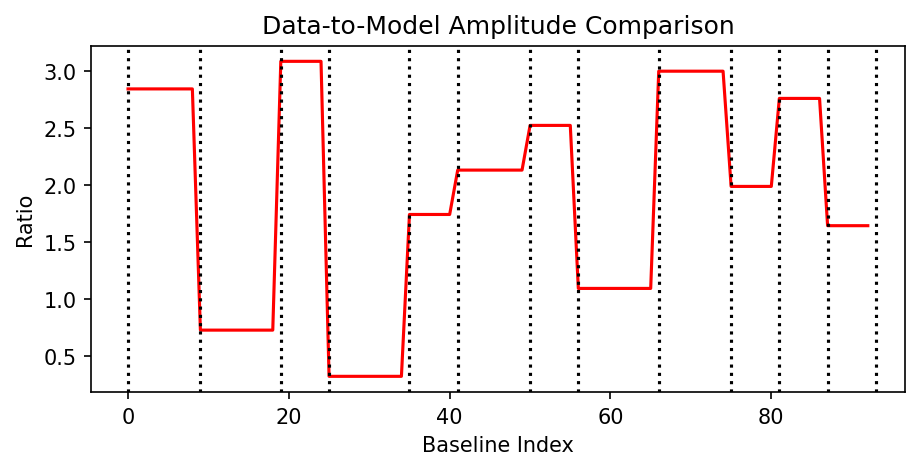

In [29]:
# Now do a quick sanity check
src_data = np.array(
    [
        src_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Ratio")
ax.set_title("Data-to-Model Amplitude Comparison")
ax.plot(np.abs(src_data) / np.abs(src_mat.sum(axis=1)), color='r')
for idx in edges:
    ax.axvline(idx, color='k', ls=':');

## Run Calibration

With the diffuse matrix and source matrix in hand, we have almost all of the ingredients we need to run the calibration. In addition to the source and diffuse matrices, we need to compute an estimate of the noise, sort the data into redundant groups, and come up with an initial guess at the gains. Since this is a simulation-based tutorial, we will simulate the gains on the fly and choose an initial guess nearby the true values.

### Sorting into Redundant Groups

There are many ways to go about sorting the data into redundant groups, but at the very least each of these must produce an `edges` array that denotes where each redundant group starts and stops. The `edges` array should be configured so that `slice(edges[i], edges[i+1])` gives all of the data (or covariance elements) for redundant group `i`. The method used for generating the `edges` array must also produce the `ant_1_array` and `ant_2_array` objects, which keep track of which antennas are used to form the baselines used in calibration.  
  
Additionally, not all baselines need to be used for calibration&mdash;the vanilla version of `CorrCal` assumes that there are no correlations between different redundant groups, and this assumption is particularly bad for the shortest baselines in a compact array, since the beam kernels for these groups have substantial $uv$-overlap. In addition to this, the number of eigenmodes that may be used for calibration are limited by the size of the smallest group used for calibration, so approaches that try to capture some of the non-redundancy in the eigenspectrum should discard groups with fewer baselines than the number of eigenmodes that are kept. This example shows how to compute the `edges` array and sort the data using `pyuvdata`.  
  
Note that we already did this earlier using the convenience function in `corrcal`, but it is worthwhile to see one approach explicitly.

In [30]:
# Initialize things for making the groups.
reds, _, lens, conj = uvdata.get_redundancies(include_conjugates=True)
conj = set(conj)  # To make lookup faster
ant_1_array = []
ant_2_array = []
edges = [0,]
idx = 0  # To count where we are when building the arrays

# Loop over the redundant groups and build the relevant arrays.
for group, bl_length in zip(reds, lens):
    if (bl_length < min_bl_length) or (len(group) < min_group_size):
        continue
    
    for bl in group:
        # Convert the baseline number into an antenna pair
        ai, aj = uvdata.baseline_to_antnums(bl)
        if bl in conj:
            ai, aj = aj, ai
        ant_1_array.append(ai)
        ant_2_array.append(aj)
        idx += 1
    edges.append(idx)
    
ant_1_array = np.array(ant_1_array)
ant_2_array = np.array(ant_2_array)
edges = np.array(edges)

In [31]:
# There is also a convenience function for this in corrcal
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_length=min_bl_length, min_group_size=min_group_size
)

In [32]:
# Now we can use these arrays to retrieve the data.
data = np.array(
    [
        uvdata.get_data(ai, aj, "xx").flatten()[0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

### Noise Estimation

In an actual calibration scenario, the noise should be estimated directly from the data. This can be done through differencing nearest neighbors (with an arbitrary choice of weighting kernel, as long as it's sensible), or by employing the radiometer equation. Since we're not including any noise in this simulation, we'll just use the noise matrix as a normalization term to help with inversion stability.

In [33]:
autocorr = uvdata.get_data(0, 0, "xx")[0,0]
noise_amp = 1e-4 * autocorr  # This is radiometer with dnu dt = 1e8
noise = np.ones(ant_1_array.size, dtype=complex) * noise_amp

### Gain Simulation

Now that we have the data sorted into redundant groups and the last piece of the covariance matrix, we can simulate the gains and produce an initial guess at the gains. To keep things simple, but not trivial, we'll take the gain amplitudes to be distributed like $|g| \sim \mathcal{N}(1, 0.1^2)$, while the phases will be uniformly distributed on $[0,2\pi)$. The initial guess will have about 10% amplitude errors and 0.05 radian phase errors. These are arbitrarily chosen; feel free to experiment with how initial guess accuracy propagates to the calibration solutions and impacts the convergence time.

In [34]:
# Choose some gain parameters
gain_amp = 1
amp_jitter = 0.1  # 10% jitter in the true gain amplitudes
amp_error = 0.1  # 10% errors in the initial guesses for the gains
phs_error = 0.05  # average error on the gain phase, in radians

# Simulate the gains
n_ants = uvdata.Nants_data
gain_amplitudes = np.random.normal(
    size=n_ants, loc=gain_amp, scale=amp_jitter
)
gain_phases = np.random.uniform(0, 2*np.pi, n_ants)
true_gains = gain_amplitudes * np.exp(1j*gain_phases)

# Now take a perturbation on the true gains as the initial guess
init_amp = gain_amplitudes * np.random.normal(
    size=n_ants, loc=1, scale=amp_error
)
init_phs = gain_phases + np.random.normal(
    size=n_ants, loc=0, scale=phs_error
)
init_gains = init_amp * np.exp(1j*init_phs)

In [35]:
# Now apply the gains to the data.
data *= true_gains[ant_1_array] * true_gains[ant_2_array].conj()

### Running the Minimizer

`CorrCal` performs calibration by minimizing the negative log-likelihood  
  
$$
    -\log\mathcal{L} = \log{\rm det} C + d^\dagger C^{-1} d,
$$
  
where $d$ is the visibility data being calibrated. Routines for computing the likelihood and its gradient are provided in the `optimize` module. This section shows how to initialize a sparse covariance object and run calibration using `scipy` for optimization.

In [36]:
# Create the sparse covariance object.
cov = corrcal.sparse.SparseCov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=src_mat,
    edges=edges,
    n_eig=n_eig,
    isinv=False,
)

In [73]:
# Set up the additional arguments the objective function needs.
gain_scale = 1  # Scaling factor to help with convergence time.
phs_norm = 0.1  # How close to zero phase the calibration solutions should be.
opt_args = (
    cov, data, ant_1_array, ant_2_array, gain_scale, phs_norm
)

# Split up the gains into the real/imaginary parts for calibration.
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = init_gains.real
split_gains[1::2] = init_gains.imag

# Now run the optimization.
result = minimize(
    corrcal.optimize.nll,
    gain_scale*split_gains,
    args=opt_args,
    method="CG",  # Use the conjugate-gradient solver
    jac=corrcal.optimize.grad_nll,
    options=dict(retall=True),
)

Unknown solver options: retall


### Inspect Calibration Results

In [38]:
gain_soln = corrcal.utils.rephase_to_ant(
    result.x[::2] + 1j*result.x[1::2], 0
)
true_gains = corrcal.utils.rephase_to_ant(true_gains, 0)

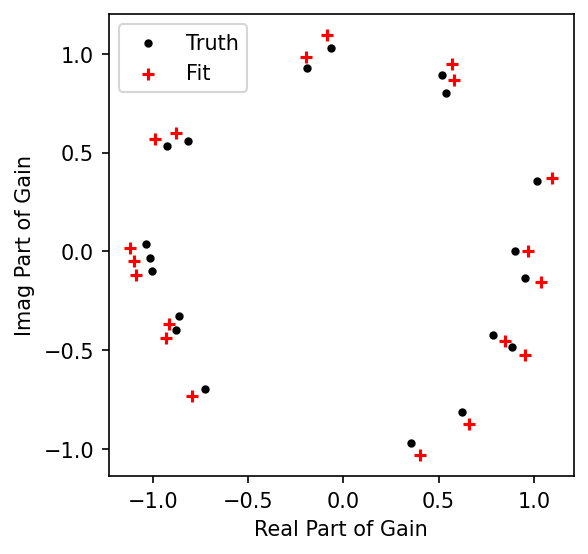

In [39]:
# First, let's look at the gain solutions in the complex plane.
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_xlabel("Real Part of Gain")
ax.set_ylabel("Imag Part of Gain")

ax.scatter(true_gains.real, true_gains.imag, color="k", marker=".", label="Truth")
ax.scatter(gain_soln.real, gain_soln.imag, color="r", marker="+", label="Fit")
ax.legend();

**Figure ? |** Gains plotted in the complex plane. The black dots mark the true gains, while the red crosses mark the fit gains. While the calibration is not perfect, the relative phases look quite close and the flux scale is close to correct. Keep in mind that this calibration was performed using only an estimate of the diffuse sky power spectrum and *one* point source.

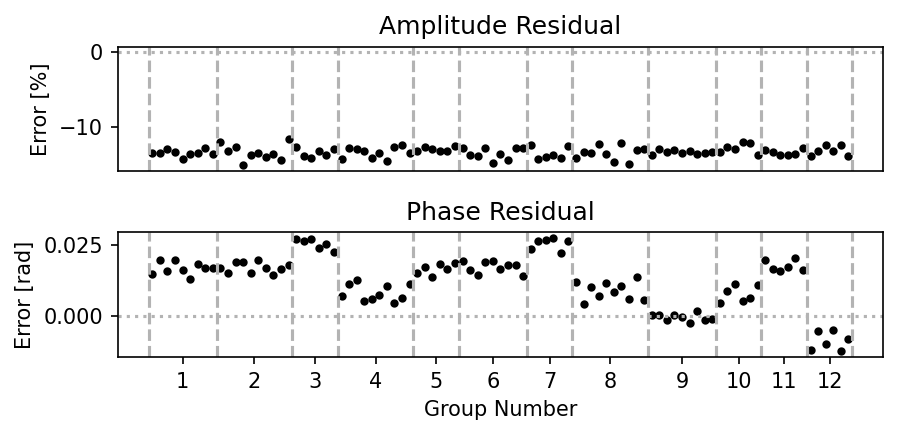

In [40]:
# Now let's look at the calibrated data.
fig, axes = plt.subplots(2, 1, figsize=(6,3), dpi=150)
axes[1].set_xlabel("Group Number")
axes[0].set_title("Amplitude Residual")
axes[1].set_title("Phase Residual")
axes[0].set_ylabel("Error [%]")
axes[1].set_ylabel("Error [rad]")

true_data = np.array(
    [
        uvdata.get_data(ai, aj, "xx")[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)
true_gain_mat = true_gains[ant_1_array] * true_gains[ant_2_array].conj()
fit_gain_mat = gain_soln[ant_1_array] * gain_soln[ant_2_array].conj()
cal_data = true_data * true_gain_mat / fit_gain_mat
amp_resid = 100 * (
    np.abs(cal_data) - np.abs(true_data)
) / np.abs(true_data)
phs_resid = np.angle(true_data * cal_data.conj())

axes[0].plot(
    0.5 + np.arange(ant_1_array.size), amp_resid, color="k", marker=".", lw=0
)
axes[1].plot(
    0.5 + np.arange(ant_1_array.size), phs_resid, color="k", marker=".", lw=0
)

for ax in axes:
    ax.axhline(0, color="0.7", ls=":")
    for edge in edges:
        ax.axvline(edge, color="0.7", ls="--")

axes[1].set_xticks(0.5 * (edges[1:] + edges[:-1]))
axes[1].set_xticklabels(range(1,len(edges)))        
axes[0].xaxis.set_visible(False)
fig.tight_layout();

**Figure ? |** Amplitude and phase residuals of the calibrated data. The top panel shows the fractional error in the calibrated visibility amplitude, while the bottom panel shows the phase error in the calibrated visibilities. Note that the amplitude is biased, but fluctuations about this offset are small. Also note that while phase errors may deviate a bit from zero, there is very little scatter within each redundant group&mdash;this indicates that calibration errors should only lead to small levels of decoherence when redundantly averaging data. Remember that this calibration only used a single (albeit bright) source for phase calibration. As a closing note, it is worthwhile to rerun the calibration for different gain realizations; sometimes the solver starts off in an unfortunate part of parameter space that it has difficulty escaping, while other times it can lock in on a rather good solution.

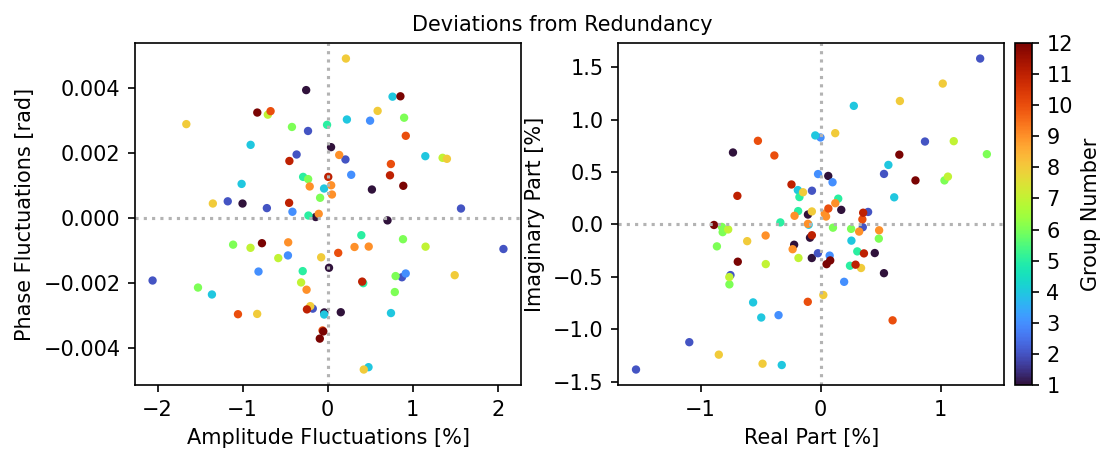

In [67]:
# Now let's look at fluctuations about the redundant average for each group.
amp_fluctuations = np.zeros(cal_data.size, dtype=float)
phs_fluctuations = np.zeros(cal_data.size, dtype=float)
vis_fluctuations = np.zeros(cal_data.size, dtype=complex)
group_ids = np.zeros(cal_data.size, dtype=float)

for i, (start, stop) in enumerate(zip(edges, edges[1:]), 1):
    group = cal_data[start:stop]
    red_avg = group.mean()
    amp_fluctuations[start:stop] = 100 * (
        np.abs(group) - np.abs(red_avg)
    ) / np.abs(red_avg)
    phs_fluctuations[start:stop] = np.angle(group * red_avg.conj())
    group_ids[start:stop] = i
    vis_fluctuations[start:stop] = 100 * (
        group - red_avg
    ) / np.abs(red_avg)
    
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
axes[0].set_xlabel("Amplitude Fluctuations [%]")
axes[0].set_ylabel("Phase Fluctuations [rad]")
axes[1].set_xlabel("Real Part [%]")
axes[1].set_ylabel("Imaginary Part [%]")
fig.text(0.475, 0.99, "Deviations from Redundancy", ha="center", va="center")
for ax in axes:
    ax.axvline(0, color='0.7', ls=':')
    ax.axhline(0, color='0.7', ls=':')
axes[1].scatter(vis_fluctuations.real, vis_fluctuations.imag, c=group_ids, marker='.', cmap=plt.cm.turbo)
cax = axes[0].scatter(amp_fluctuations, phs_fluctuations, c=group_ids, marker='.', cmap=plt.cm.turbo)

fig.tight_layout()
cbar = fig.colorbar(cax, ax=axes, label="Group Number", pad=0.01)
cbar.set_ticks(np.arange(1, edges.size))

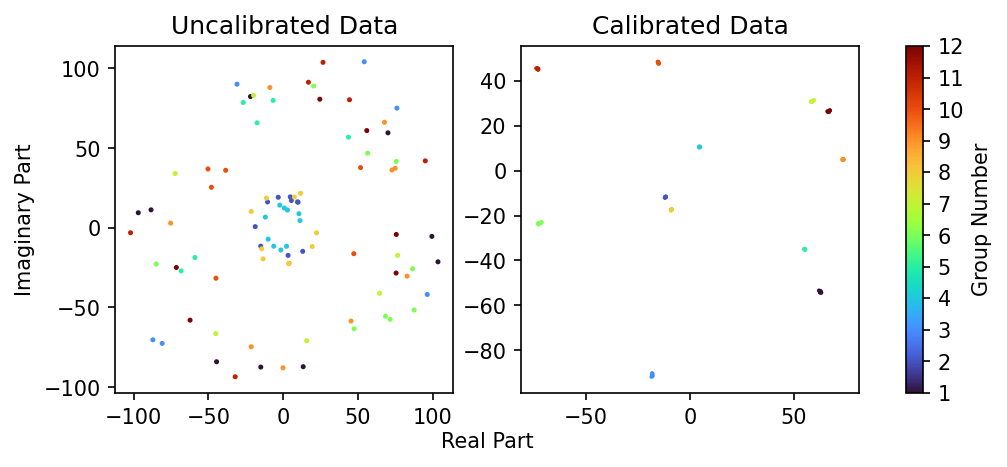

In [69]:
# To help put things into context, let's compare against uncalibrated data
uncal_data = true_gain_mat * true_data
plot_kwds = dict(
    c=group_ids,
    cmap=plt.cm.turbo,
)
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
fig.text(0.435, 0, "Real Part", ha="center", va="center")
axes[0].set_ylabel("Imaginary Part")
axes[0].set_title("Uncalibrated Data")
axes[1].set_title("Calibrated Data")
axes[0].scatter(uncal_data.real, uncal_data.imag, s=2, **plot_kwds)
cax = axes[1].scatter(cal_data.real, cal_data.imag, s=1, **plot_kwds)
cbar = fig.colorbar(cax, ax=axes, label="Group Number")
cbar.set_ticks(np.arange(1, edges.size));

In [ ]:
# TODO: add a flux amplitude and phase gradient calibration?